## Inspect Dataset

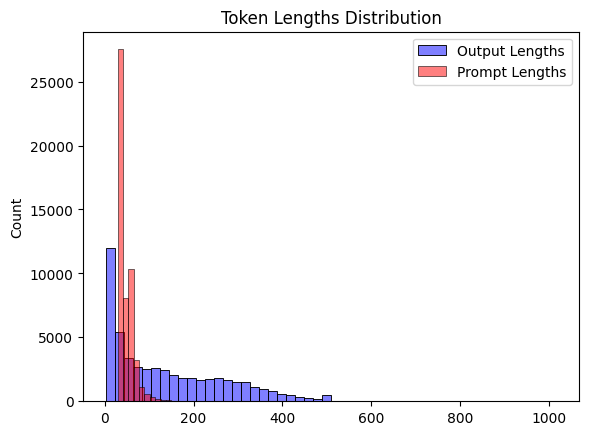

In [5]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from utils.prompter import Prompter
import seaborn as sns

prompter = Prompter()
dataset = load_dataset("yahma/alpaca-cleaned")
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.1-8B")

# make statistics for the dataset["output"] column's token lengths and plot them
len_data = dataset["train"].map(
    lambda x: {
        'output_len': len(tokenizer(x["output"])["input_ids"]),
        'prompt_len': len(tokenizer(prompter.generate_prompt(x["instruction"], x["input"]))["input_ids"])
    }
)

# plot a list of lengths to see the histogram distribution
import matplotlib.pyplot as plt

sns.histplot(len_data["output_len"], bins=50, color='blue', alpha=0.5, label='Output Lengths')
sns.histplot(len_data["prompt_len"], bins=50, color='red', alpha=0.5, label='Prompt Lengths')

plt.title("Token Lengths Distribution")
plt.legend()
plt.show()

## Try to backpropagate loss only on completion tokens

In [1]:
import transformers
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from datasets import load_dataset
from trl import SFTConfig, SFTTrainer, DataCollatorForCompletionOnlyLM
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model
from utils.prompter import Prompter

dataset = load_dataset("yahma/alpaca-cleaned")
prompter = Prompter()
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)
model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-3.1-8B", 
    device_map="auto",
    quantization_config=bnb_config,
)
model = prepare_model_for_kbit_training(model)
lora_config = LoraConfig(
        r=8,
        lora_alpha=16,
        target_modules=['q_proj', 'k_proj', 'v_proj', 'o_proj'],
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM",
    )
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.1-8B")
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(data_point):
    full_prompt = prompter.generate_prompt(
        data_point["instruction"],
        data_point["input"],
        data_point["output"],
    )

    full_prompt_tokens = tokenizer.encode(full_prompt, return_tensors="pt")
    output_tokens = tokenizer.encode(data_point["output"], return_tensors="pt")

    response_start_index = full_prompt_tokens.shape[1] - output_tokens.shape[1] 

    return {
        "text": full_prompt, 
        "response_start_index": response_start_index
    }

new_dataset = dataset["train"].map(generate_and_tokenize_prompt)
new_dataset.remove_columns(["instruction", "input", "output"])


/opt/conda/envs/alpaca-qlora/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 4/4 [00:07<00:00,  1.99s/it]


trainable params: 6,815,744 || all params: 8,037,076,992 || trainable%: 0.0848


Dataset({
    features: ['text', 'response_start_index'],
    num_rows: 51760
})

In [5]:
def print_tokens_with_ids(txt):
    tokens = tokenizer.tokenize(txt, add_special_tokens=False)
    token_ids = tokenizer.encode(txt, add_special_tokens=False)
    print(list(zip(tokens, token_ids)))

prompt = """Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\n{instruction}\n\n### Response:\n"""
print_tokens_with_ids(prompt)  # [..., ('▁Hello', 15043), ('<0x0A>', 13), ('<0x0A>', 13), ('##', 2277), ('#', 29937), ('▁Ass', 4007), ('istant', 22137), (':', 29901), ...]

response_template = "\n\n### Response:\n"
print_tokens_with_ids(response_template)  # [('▁###', 835), ('▁Ass', 4007), ('istant', 22137), (':', 29901)]

[('Below', 39314), ('Ġis', 374), ('Ġan', 459), ('Ġinstruction', 7754), ('Ġthat', 430), ('Ġdescribes', 16964), ('Ġa', 264), ('Ġtask', 3465), ('.', 13), ('ĠWrite', 9842), ('Ġa', 264), ('Ġresponse', 2077), ('Ġthat', 430), ('Ġappropriately', 36001), ('Ġcompletes', 45695), ('Ġthe', 279), ('Ġrequest', 1715), ('.ĊĊ', 382), ('###', 14711), ('ĠInstruction', 30151), (':Ċ', 512), ('{', 90), ('instruction', 56074), ('}ĊĊ', 633), ('###', 14711), ('ĠResponse', 6075), (':Ċ', 512)]
[('ĊĊ', 271), ('###', 14711), ('ĠResponse', 6075), (':Ċ', 512)]


In [ ]:
from typing import List
import os

# parameter for trainer
base_model: str = ""  # the only required argument
data_path: str = "yahma/alpaca-cleaned"
output_dir: str = "./lora-alpaca"
device_map: str = "auto"
# training hyperparams
batch_size: int = 128
micro_batch_size: int = 4
num_epochs: int = 3
learning_rate: float = 3e-4
cutoff_len: int = 256
val_set_size: int = 2000
# lora hyperparams
lora_r: int = 8
lora_alpha: int = 16
lora_dropout: float = 0.05
lora_target_modules: List[str] = [
    "q_proj",
    "v_proj",
]
# llm hyperparams
train_on_inputs: bool = True  # if False, masks out inputs in loss
add_eos_token: bool = False
group_by_length: bool = False  # faster, but produces an odd training loss curve
# wandb params
wandb_project: str = ""
wandb_run_name: str = ""
wandb_watch: str = ""  # options: false | gradients | all
wandb_log_model: str = ""  # options: false | true
resume_from_checkpoint: str = None  # either training checkpoint or final adapter
prompt_template_name: str = "alpaca"  # The prompt template to use, will default to alpaca.
# experimental
use_landmark: bool = False
use_rope_scaled: bool = False

In [3]:
# parameter override
num_epochs = 1
micro_batch_size = 16
val_set_size = 0

In [4]:
instruction_template = "### Instruction:\n"
response_template = "### Response:\n"
collator = DataCollatorForCompletionOnlyLM(instruction_template=instruction_template, response_template=response_template, tokenizer=tokenizer, mlm=False)


gradient_accumulation_steps = batch_size // micro_batch_size
world_size = int(os.environ.get("WORLD_SIZE", 1))
ddp = world_size != 1
if ddp:
    device_map = {"": int(os.environ.get("LOCAL_RANK") or 0)}
    gradient_accumulation_steps = gradient_accumulation_steps // world_size

# Check if parameter passed or if set within environ
use_wandb = len(wandb_project) > 0 or (
    "WANDB_PROJECT" in os.environ and len(os.environ["WANDB_PROJECT"]) > 0
)
use_wandb = False

training_args = SFTConfig(
    per_device_train_batch_size=micro_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    warmup_steps=100,
    num_train_epochs=num_epochs,
    learning_rate=learning_rate,
    bf16=True,
    logging_steps=10,
    optim="paged_adamw_8bit",
    evaluation_strategy="steps" if val_set_size > 0 else "no",
    save_strategy="steps",
    eval_steps=100 if val_set_size > 0 else None,
    save_steps=100,
    output_dir=output_dir,
    save_total_limit=3,
    #load_best_model_at_end=True if val_set_size > 0 else False,
    load_best_model_at_end=False,
    ddp_find_unused_parameters=False if ddp else None,
    group_by_length=group_by_length,
    report_to="wandb" if use_wandb else None,
    run_name=wandb_run_name if use_wandb else None,
)

trainer = SFTTrainer(
    model,
    args=training_args,
    train_dataset=new_dataset,
    eval_dataset=None,
    data_collator=collator,
)

for batch in trainer.get_train_dataloader():
    print(len(batch), batch)
    break

batch['labels'][batch["labels"] == -100] = tokenizer.encode("_", add_special_tokens=False)[0]
inputs = tokenizer.batch_decode(batch["input_ids"])
targets = tokenizer.batch_decode(batch["labels"])
print("batch_size:", len(inputs))
print(inputs[1])
print("*" * 50)
print(targets[1])

/opt/conda/envs/alpaca-qlora/lib/python3.12/site-packages/trl/trainer/utils.py:134: UserWarning: The pad_token_id and eos_token_id values of this tokenizer are identical. If you are planning for multi-turn training, it can result in the model continuously generating questions and answers without eos token. To avoid this, set the pad_token_id to a different value.
  warnings.warn(
/opt/conda/envs/alpaca-qlora/lib/python3.12/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/envs/alpaca-qlora/lib/python3.12/site-packages/trl/trainer/sft_trainer.py:309: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


3 {'input_ids': tensor([[128000,  39314,    374,  ..., 128001, 128001, 128001],
        [128000,  39314,    374,  ..., 128001, 128001, 128001],
        [128000,  39314,    374,  ..., 128001, 128001, 128001],
        ...,
        [128000,  39314,    374,  ..., 128001, 128001, 128001],
        [128000,  39314,    374,  ...,    872,  23277,     13],
        [128000,  39314,    374,  ..., 128001, 128001, 128001]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0'), 'labels': tensor([[ -100,  -100,  -100,  ...,  -100,  -100,  -100],
        [ -100,  -100,  -100,  ...,  -100,  -100,  -100],
        [ -100,  -100,  -100,  ...,  -100,  -100,  -100],
        ...,
        [ -100,  -100,  -100,  ...,  -100,  -100,  -100],
        [ -100,  -100,  -100,  ...,   872, 23277,   

In [ ]:
trainer.train()